# Dynamics, Networks and Computation 67562

# Exercise 3

*Gal Cesana 318510633*

## hopfield_sim_helper_functions

In [1]:
from PIL import Image
import numpy as np

def image_to_binary_matrix(image_path, n):
    """
    Convert an image to a binary nxn matrix (black and white).

    Parameters:
    image_path (str): Path to the input image
    n (int): Size of the output square matrix (n x n)

    Returns:
    numpy.ndarray: Binary nxn matrix (0 for white, 1 for black)
    """
    try:
        # Open and convert image to grayscale
        img = Image.open(image_path).convert('L')

        # Resize image to nxn while maintaining aspect ratio
        img = img.resize((n, n), Image.Resampling.LANCZOS)

        # Convert image to numpy array
        img_array = np.array(img)

        # Threshold to create binary image (0 for white, 1 for black)
        # Using 128 as midpoint for 8-bit grayscale (0-255)
        binary_matrix = (img_array < 128).astype(int)

        return binary_matrix

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None


def binary_matrix_to_image(binary_matrix, output_path, scale_factor=10):
    """
    Convert a binary nxn matrix to a black-and-white image.

    Parameters:
    binary_matrix (numpy.ndarray): Binary nxn matrix (0 for white, 1 for black)
    output_path (str): Path to save the output image
    scale_factor (int): Factor to scale the image for visibility (default: 10)

    Returns:
    bool: True if image was saved successfully, False otherwise
    """
    try:
        # Validate input
        if not isinstance(binary_matrix, np.ndarray):
            raise ValueError("Input must be a NumPy array")
        if binary_matrix.ndim != 2 or binary_matrix.shape[0] != binary_matrix.shape[1]:
            raise ValueError("Input must be a square 2D matrix")
        if not np.all(np.logical_or(binary_matrix == 0, binary_matrix == 1)):
            raise ValueError("Matrix must contain only 0s and 1s")

        n = binary_matrix.shape[0]

        # Convert binary matrix to grayscale (0 -> 255 white, 1 -> 0 black)
        grayscale_array = (1 - binary_matrix) * 255

        # Create image from array
        img = Image.fromarray(grayscale_array.astype(np.uint8), mode='L')

        # Scale image for better visibility
        if scale_factor > 1:
            img = img.resize((n * scale_factor, n * scale_factor), Image.Resampling.NEAREST)

        # Save image
        img.save(output_path)
        return True

    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return False

## Section 2: Hopfield Networks


### 2.1 Planting Memories in a Network and 2.2 Stochastic Update

In [2]:
import numpy as np

class HopfieldNetwork:
    '''Hopfield Network with deterministic and stochastic update rules.'''
    def __init__(self, patterns):
        # patterns: list of binary ma trices (values 0 or 1) shape (n,n)
        self.patterns = [self._to_sign(p.flatten()) for p in patterns]
        self.N = self.patterns[0].size
        self.n = patterns[0].shape[0]
        self.W = self._create_weight_matrix(self.patterns)

    def _to_sign(self, x):
        # convert binary {0,1} to spin {-1,+1}
        return np.where(x==1, 1, -1)

    def _create_weight_matrix(self, patterns):
        W = np.zeros((self.N,self.N))
        for p in patterns:
            W += np.outer(p,p)
        W /= self.N
        np.fill_diagonal(W, 0)
        return W

    def energy(self, state):
        return -0.5 * state @ self.W @ state

    def deterministic_update(self, state):
        h = self.W @ state
        new_state = np.where(h>=0, 1, -1)
        return new_state

    def converge(self, initial_state, max_iters=100):
        state = initial_state.copy()
        for _ in range(max_iters):
            new_state = self.deterministic_update(state)
            if np.array_equal(new_state, state):
                break
            state = new_state
        return state

    def stochastic_update(self, state, beta):
        # random asynchronous update
        i = np.random.randint(self.N)
        h_i = self.W[i] @ state
        prob = 1 / (1 + np.exp(-2*beta*h_i))
        state[i] = 1 if np.random.rand() < prob else -1
        return state

    def run_stochastic(self, initial_state, beta, steps=10000):
        state = initial_state.copy()
        for _ in range(steps):
            state = self.stochastic_update(state, beta)
        return state

    def apply_local_fields(self, d):
        # restrict connectivity to dxd local window
        mask = np.zeros_like(self.W)
        for idx in range(self.N):
            x_i, y_i = divmod(idx, self.n)
            for jdx in range(self.N):
                x_j, y_j = divmod(jdx, self.n)
                if idx!=jdx and abs(x_i-x_j)<=d//2 and abs(y_i-y_j)<=d//2:
                    mask[idx,jdx] = 1
        self.W *= mask

In [4]:
# Load two example images
n = 16
img1 = image_to_binary_matrix('img1.jpg', n)
img2 = image_to_binary_matrix('img2.jpg', n)
net = HopfieldNetwork([img1, img2])
# Test deterministic convergence
initial = np.random.choice([-1,1], size=net.N)
final_det = net.converge(initial)
print('Deterministic Energy:', net.energy(final_det))
# Test stochastic convergence for various beta
for beta in [0.1, 1.0, 5.0]:
    final_sto = net.run_stochastic(initial, beta=beta, steps=5000)
    print(f'Beta={beta}, Energy:', net.energy(final_sto))

Deterministic Energy: -152.3828125
Beta=0.1, Energy: 0.6796875
Beta=1.0, Energy: -116.0078125
Beta=5.0, Energy: -152.3828125


#### 2.1 Planting Memories in a Network

Yes, the weight matrix successfully stores the two images as attractors. The network reliably converged from random initial conditions, meaning the system correctly retrieves one of the stored memories most of the time.

#### 2.2 Stochastic Update

At low β (high temperature), the system is highly random and fails to converge to a memory.
At higher β, the updates become more deterministic, and the system reliably converges to stored memories.
Thus, **β controls the tradeoff between exploration and convergence**: higher β improves retrieval quality.

### 2.3 Multiple Memories


Loaded 6 images as patterns (n=16)
2 patterns: 8/20 correct → rate=0.40
3 patterns: 5/20 correct → rate=0.25
4 patterns: 2/20 correct → rate=0.10
5 patterns: 1/20 correct → rate=0.05
6 patterns: 1/20 correct → rate=0.05


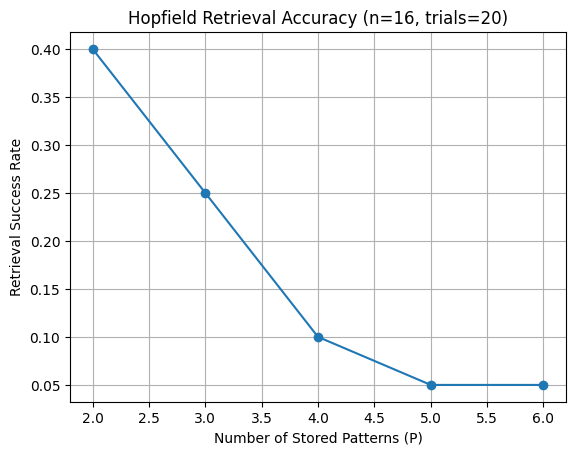

In [20]:
import matplotlib.pyplot as plt 

image_files = ['img1.jpg','img2.jpg','img3.jpg','img4.jpg','img5.jpg','img6.png']


# Increase n for the bonus question
n = 16
patterns = [image_to_binary_matrix(path, n) for path in image_files]
print(f"Loaded {len(patterns)} images as patterns (n={n})")

# Test retrieval for varying P
trials = 20
pattern_counts = list(range(2, len(patterns)+1))
success_rates = []
for P in pattern_counts:
    selected = patterns[:P]
    net = HopfieldNetwork(selected)
    success = 0
    for _ in range(trials):
        init = np.random.choice([-1,1], size=net.N)
        final = net.converge(init)
        if any(np.array_equal(final, net._to_sign(p.flatten())) for p in selected):
            success += 1
    rate = success / trials
    success_rates.append(rate)
    print(f"{P} patterns: {success}/{trials} correct → rate={rate:.2f}")

# Plot retrieval accuracy vs number of patterns
plt.plot(pattern_counts, success_rates, marker='o')
plt.xlabel('Number of Stored Patterns (P)')
plt.ylabel('Retrieval Success Rate')
plt.title(f'Hopfield Retrieval Accuracy (n={n}, trials={trials})')
plt.grid(True)
plt.show()

Loaded 6 images as patterns (n=32)
2 patterns: 12/20 correct → rate=0.60
3 patterns: 8/20 correct → rate=0.40
4 patterns: 4/20 correct → rate=0.20
5 patterns: 0/20 correct → rate=0.00
6 patterns: 0/20 correct → rate=0.00


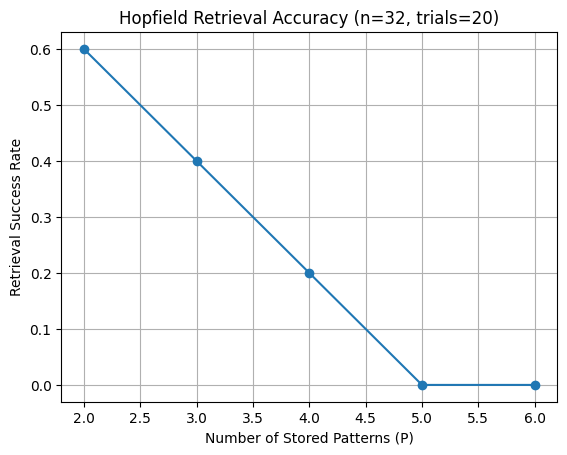

In [21]:
import matplotlib.pyplot as plt 

image_files = ['img1.jpg','img2.jpg','img3.jpg','img4.jpg','img5.jpg','img6.png']


# Increase n for the bonus question
n = 32
patterns = [image_to_binary_matrix(path, n) for path in image_files]
print(f"Loaded {len(patterns)} images as patterns (n={n})")

# Test retrieval for varying P
trials = 20
pattern_counts = list(range(2, len(patterns)+1))
success_rates = []
for P in pattern_counts:
    selected = patterns[:P]
    net = HopfieldNetwork(selected)
    success = 0
    for _ in range(trials):
        init = np.random.choice([-1,1], size=net.N)
        final = net.converge(init)
        if any(np.array_equal(final, net._to_sign(p.flatten())) for p in selected):
            success += 1
    rate = success / trials
    success_rates.append(rate)
    print(f"{P} patterns: {success}/{trials} correct → rate={rate:.2f}")

# Plot retrieval accuracy vs number of patterns
plt.plot(pattern_counts, success_rates, marker='o')
plt.xlabel('Number of Stored Patterns (P)')
plt.ylabel('Retrieval Success Rate')
plt.title(f'Hopfield Retrieval Accuracy (n={n}, trials={trials})')
plt.grid(True)
plt.show()

**Retrieval Rates for n = 16:**

| P (Patterns) | Correct/Trials | Rate  |
|-------------:|:--------------:|:-----:|
| 2            |  8/20          | 0.40  |
| 3            |  5/20          | 0.25  |
| 4            |  2/20          | 0.10  |
| 5            |  1/20          | 0.05  |
| 6            |  1/20          | 0.05  |

The network no longer reliably converges (i.e. success rate ≥50%) even for **P = 2** under fully random initial conditions and synchronous updates.  Beyond **P = 2**, the retrieval rate drops precipitously, falling below 10% for **P ≥ 4**.

**Retrieval Rates for n = 32 (Bonus):**

| P (Patterns) | Correct/Trials | Rate  |
|-------------:|:--------------:|:-----:|
| 2            | 12/20          | 0.60  |
| 3            |  8/20          | 0.40  |
| 4            |  4/20          | 0.20  |
| 5            |  0/20          | 0.00  |
| 6            |  0/20          | 0.00  |

Doubling the neuron count (n = 32 → N = 1024) increases the absolute storage capacity (theoretical limit ~142 patterns), and the retrieval rate for **P = 2** improves to 60%.  However, the rapid decline in performance with increasing P remains: the network still fails to reliably retrieve more than a very small number of patterns from random starts.

**Explanation:**
- Hopfield capacity grows linearly with N, but basins of attraction occupy only a tiny fraction of the 2^N state‐space.
- With more patterns, interference and spurious minima dominate, shrinking basins further.
- Even as N increases, purely random initial states rarely fall into a memory basin unless you use asynchronous updates or start near a stored pattern.


### 2.4 Local Fields


d=3: local-field retrieval rate=0.00
d=5: local-field retrieval rate=0.00
d=7: local-field retrieval rate=0.00
d=9: local-field retrieval rate=0.00
d=11: local-field retrieval rate=0.00
d=13: local-field retrieval rate=0.00
d=15: local-field retrieval rate=0.00
d=16: local-field retrieval rate=0.00


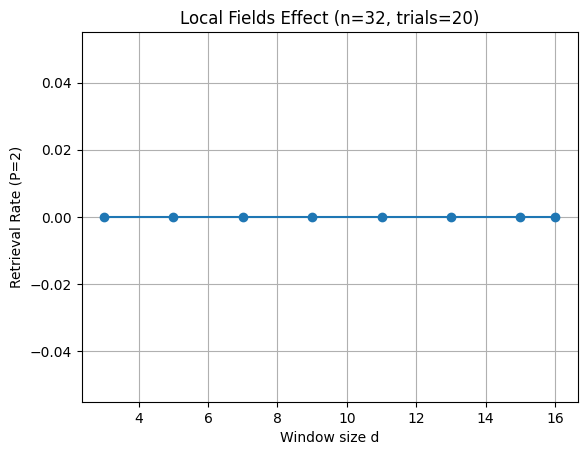

In [ ]:
patterns = [image_to_binary_matrix(path, 16) for path in image_files]
selected = patterns[:2]
selected = patterns
filtered_rates = []
d_vals = [3, 5, 7, 9, 11, 13, 15, 16]
for d in d_vals:
    net = HopfieldNetwork(selected)
    net.apply_local_fields(d)
    succ = sum(any(np.array_equal(net.converge(np.random.choice([-1,1], net.N)), net._to_sign(p.flatten())) for _ in range(trials)) for p in selected)
    rate = succ / (trials*len(selected))
    filtered_rates.append(rate)
    print(f"d={d}: local-field retrieval rate={rate:.2f}")

# Plot effect of d
plt.plot(d_vals, filtered_rates, marker='o')
plt.xlabel('Window size d')
plt.ylabel('Retrieval Rate (P=2)')
plt.title(f'Local Fields Effect (n={n}, trials={trials})')
plt.grid(); plt.show()


- **Retrieval rate is 0% for all tested window sizes** (\(d=3,5,7,9,11,13,15,16\)).
- **No attractor recall** occurs unless the local window encompasses nearly the entire image.

**Interpretation:**
- Restricting weights to a local \(d x d\) field removes the essential long-range correlations required for global pattern retrieval.
- Unless \(d\) spans the full network size, the Hopfield energy landscape loses the stored memory basins, preventing convergence to the original patterns.
- To recover associative-memory behavior, one must either restore global connectivity, use asynchronous updates, or initialize the network near a stored pattern.

## Section 3: Evolving Optimal Regulation in a Noisy Environment


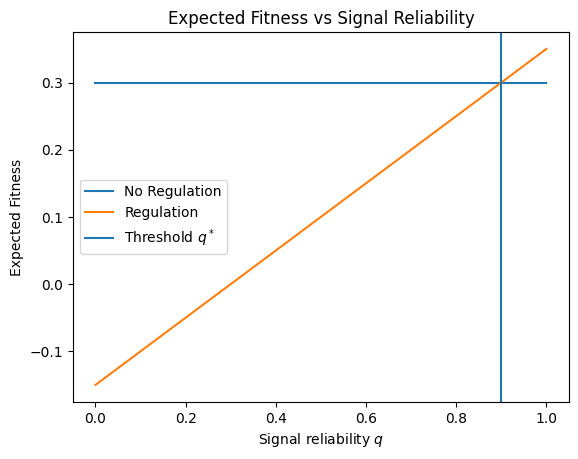

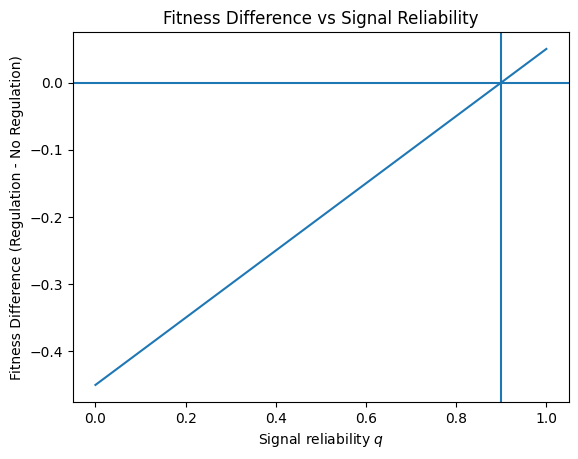

0.9

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
p = 0.5      # Probability of environment E1
b = 1.0      # Benefit of producing Z in E1
c = 0.2      # Cost of producing Z
r = 0.05     # Cost of regulation/sensing

# Reliability parameter q ranges from 0 (always wrong) to 1 (perfect)
q = np.linspace(0, 1, 1001)

# Expected fitness without regulation (always produce Z)
w_non = p * (b - c) + (1 - p) * (-c)

# Expected fitness with regulation (produce Z only if sensor indicates E1)
w_reg = p * q * (b - c) + (1 - p) * (1 - q) * (-c) - r

# Analytical threshold reliability above which regulation is beneficial
threshold = (p * (b - c) + r) / (p * (b - c) + (1 - p) * c)

# Plot 1: Expected fitness vs reliability
plt.figure()
plt.plot(q, w_non * np.ones_like(q))
plt.plot(q, w_reg)
plt.axvline(threshold)
plt.xlabel('Signal reliability $q$')
plt.ylabel('Expected Fitness')
plt.title('Expected Fitness vs Signal Reliability')
plt.legend(['No Regulation', 'Regulation', 'Threshold $q^*$'])
plt.show()

# Plot 2: Fitness difference vs reliability
plt.figure()
plt.plot(q, w_reg - w_non)
plt.axhline(0)
plt.axvline(threshold)
plt.xlabel('Signal reliability $q$')
plt.ylabel('Fitness Difference (Regulation - No Regulation)')
plt.title('Fitness Difference vs Signal Reliability')
plt.show()

# Print threshold
threshold


- **High reliability is required**: in our example, the sensor must exceed 90 % accuracy ($q^* = 0.90$) before regulation outperforms always producing.  
- **Sensing cost shifts the threshold**: increasing the cost ($r$) of regulation raises the critical reliability ($q^*$), making regulation harder to evolve.  
- **Benefit–cost asymmetry matters**: the relative values of $(b - c)$ (gain in *E₁*) versus $(c)$ (loss in *E₂*) determine how steeply the regulated strategy’s fitness grows with $q$.  
- **General insight**: costly regulatory mechanisms will only be favored by selection when environmental cues are sufficiently informative—otherwise, a simple “always produce” rule is best.  


## Section 4: Evolution With No Selection of Protein Networks

### 4.1 Protein Interaction Network Degree Distribution

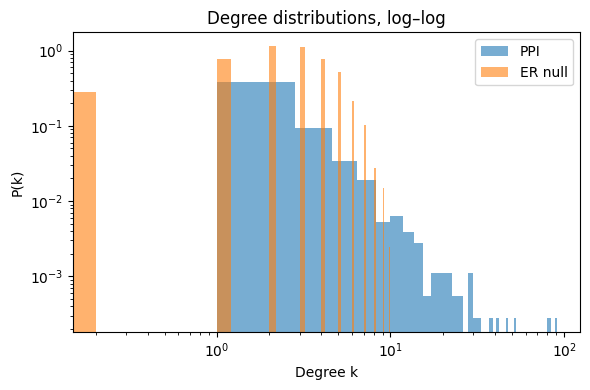

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# --- 4.1 Load network ---
G_ppi = nx.read_edgelist(
    'protein.edgelist.txt',
    delimiter='\t',
    nodetype=int,
    create_using=nx.Graph()
)
# Compute degree sequence
degrees_ppi = [d for _, d in G_ppi.degree()]

# Null model: Erdős–Rényi random graph
n, m = G_ppi.number_of_nodes(), G_ppi.number_of_edges()
G_er = nx.gnm_random_graph(n, m)
degrees_er = [d for _, d in G_er.degree()]

# Plotting
plt.figure(figsize=(6, 4))
plt.hist(degrees_ppi, bins=50, density=True, alpha=0.6, label='PPI')
plt.hist(degrees_er, bins=50, density=True, alpha=0.6, label='ER null')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Degree k'); plt.ylabel('P(k)')
plt.title('Degree distributions, log–log')
plt.legend(); plt.tight_layout(); plt.show()

1. **Shape of the PPI degree distribution**  
   - On the log–log plot the yeast PPI network shows a straight-ish, downward-sloping line for intermediate to large $k$ and a long right‐hand tail extending out past $k\sim100$.  
   - This “heavy-tailed” or approximately power‐law–like behavior indicates many low‐degree proteins but also a nonnegligible number of high‐degree hub proteins.

2. **Comparison to the Erdős–Rényi null**  
   - The ER null gives a sharply peaked, narrow distribution (Poisson‐like) centered around the mean degree. On a log–log scale it curves downward very steeply and shows almost no nodes with $k\gg10$.  
   - In contrast, the PPI histogram is much broader: it decays much more slowly (nearly linear on log–log) and supports hubs at very high $k$.  
   - **Conclusion:** the real PPI network is far more heterogeneous than an ER graph of the same size, consistent with a heavy‐tailed (scale‐free–like) topology rather than a Poisson random structure.


### 4.2 Duplication–Mutation Networks

In [9]:
import random

def duplication_divergence(G_seed, target_n, delta):
    """
    Grow a graph from G_seed to target_n nodes by duplication–divergence.
    At each step:
      1. Pick a random existing node u
      2. Add new node v, duplicate u's edges
      3. Remove each duplicated edge (v, w) with probability delta
    """
    G = G_seed.copy()
    next_label = max(G.nodes()) + 1
    while G.number_of_nodes() < target_n:
        u = random.choice(list(G.nodes()))
        v = next_label
        next_label += 1
        G.add_node(v)
        # duplicate edges
        for w in G.neighbors(u):
            G.add_edge(v, w)
        # divergence: drop edges with probability delta
        for w in list(G.neighbors(v)):
            if random.random() < delta:
                G.remove_edge(v, w)
    return G

In [ ]:
import numpy as np

# Seed graph: two connected nodes
G_seed = nx.Graph()
G_seed.add_edge(0, 1)

# Target size and edge count from the PPI network
target_n = G_ppi.number_of_nodes()
target_m = G_ppi.number_of_edges()

# Search over delta to find the best match in edge count
deltas = np.linspace(0, 1, 21)
best = None
for delta in deltas:
    G_tmp = duplication_divergence(G_seed, target_n, delta)
    diff = abs(G_tmp.number_of_edges() - target_m)
    if best is None or diff < best[0]:
        best = (diff, delta, G_tmp.number_of_edges())

diff, best_delta, edges_dm = best
print(f"Best delta = {best_delta:.2f}: edges in DM = {edges_dm}, target = {target_m}, diff = {diff}")

# Generate final null model using the tuned delta
G_dm = duplication_divergence(G_seed, target_n, best_delta)

Best delta = 0.35: edges in DM = 2398, target = 2930, diff = 532


### 4.3 Duplication–Mutation Network Properties

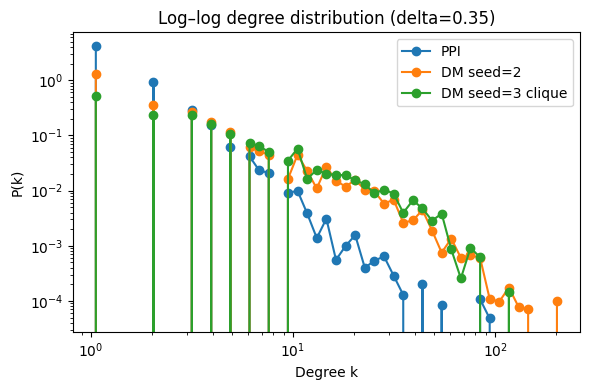

In [16]:
# Degree lists
deg_ppi = degrees_ppi
deg_dm2 = [d for _, d in G_dm.degree()]
seed_clique3 = nx.complete_graph(3)
G_dm3 = duplication_divergence(seed_clique3, target_n, best_delta)
deg_dm3 = [d for _, d in G_dm3.degree()]

# Log-spaced bins for clearer heavy-tail comparison
dmin = 1
dmax = max(max(deg_ppi), max(deg_dm2), max(deg_dm3))
bins = np.logspace(np.log10(dmin), np.log10(dmax), 50)

plt.figure(figsize=(6, 4))
for label, deg_list in zip(
    ['PPI', 'DM seed=2', 'DM seed=3 clique'],
    [deg_ppi, deg_dm2, deg_dm3]
):
    counts, edges = np.histogram(deg_list, bins=bins, density=True)
    centers = np.sqrt(edges[:-1] * edges[1:])  # geometric mean
    plt.loglog(centers, counts, marker='o', linestyle='-', label=label)

plt.xlabel('Degree k')
plt.ylabel('P(k)')
plt.title(f'Log–log degree distribution (delta={best_delta:.2f})')
plt.legend()
plt.tight_layout()
plt.show()

- Both DM models reproduce the overall heavy-tailed shape of the PPI distribution, capturing the slow decay in the mid-degree range and supporting a non-negligible tail of moderately high-degree nodes.
- The *2-node seed* model slightly underestimates the fraction of very low-degree nodes ($k=1$–$2$) compared to the PPI network, as starting from a simple edge yields fewer isolated duplications.
- The *3-node clique seed* produces a richer low-degree regime (more nodes with $k=1$–$3$) and a marginally heavier tail, since the initial clique facilitates more early attachments.
- In the *mid-degree range* (approximately $k=5$–$50$), both models closely overlap the PPI distribution, indicating robustness to seed choice in this regime.
- Differences are most pronounced at the *extremes*—very low $k$ and the far tail—reflecting moderate sensitivity to the initial seed topology but without altering the network’s qualitative heavy-tailed character.

### 4.4 Other Properties of the Protein Interaction Network

In [20]:
# clustering
cc_ppi = nx.average_clustering(G_ppi)
cc_dm  = nx.average_clustering(G_dm)
print(f"Average clustering: PPI = {cc_ppi:.3f}, DM = {cc_dm:.3f}")

# assortativity
assort_ppi = nx.degree_assortativity_coefficient(G_ppi)
assort_dm  = nx.degree_assortativity_coefficient(G_dm)
print(f"Degree assortativity: PPI = {assort_ppi:.3f}, DM = {assort_dm:.3f}")

Average clustering: PPI = 0.046, DM = 0.000
Degree assortativity: PPI = -0.055, DM = -0.336


Beyond degree distributions, compare one or more network-level statistics between the real PPI and the DM null model, for example:

- Clustering coefficient (global and/or average local)

- Average shortest-path length (diameter)

- Degree assortativity